<a href="https://colab.research.google.com/github/KhoiDOO/Practice/blob/main/ComputerVision/11.%20Variational_Autoencoders_on_Anime_Faces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Variational Autoencoders on Anime Faces

Dataset [anime faces dataset by MckInsey666](https://github.com/bchao1/Anime-Face-Dataset). 

## Imports

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
import numpy as np

import os
import zipfile
import urllib.request
import random
from IPython import display

from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Flatten, Dense, Reshape, Conv2DTranspose

## Parameters

In [ ]:
# set a random seed
np.random.seed(51)

# parameters for building the model and training
BATCH_SIZE=2000
LATENT_DIM=512
IMAGE_SIZE=64

## Download the Dataset


In [ ]:
# make the data directory
try:
  os.mkdir('/tmp/anime')
except OSError:
  pass

# download the zipped dataset to the data directory
data_url = "https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Resources/anime-faces.zip"
data_file_name = "animefaces.zip"
download_dir = '/tmp/anime/'
urllib.request.urlretrieve(data_url, data_file_name)

# extract the zip file
zip_ref = zipfile.ZipFile(data_file_name, 'r')
zip_ref.extractall(download_dir)
zip_ref.close()

## Prepare the Dataset

In [ ]:
# Data Preparation Utilities

def get_dataset_slice_paths(image_dir):
  '''returns a list of paths to the image files'''
  image_file_list = os.listdir(image_dir)
  image_paths = [os.path.join(image_dir, fname) for fname in image_file_list]

  return image_paths


def map_image(image_filename):
  '''preprocesses the images'''
  img_raw = tf.io.read_file(image_filename)
  image = tf.image.decode_jpeg(img_raw)

  image = tf.cast(image, dtype=tf.float32)
  image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
  image = image / 255.0  
  image = tf.reshape(image, shape=(IMAGE_SIZE, IMAGE_SIZE, 3,))

  return image

In [ ]:
# get the list containing the image paths
paths = get_dataset_slice_paths("/tmp/anime/images/")

# shuffle the paths
random.shuffle(paths)

# split the paths list into to training (80%) and validation sets(20%).
paths_len = len(paths)
train_paths_len = int(paths_len * 0.8)

train_paths = paths[:train_paths_len]
val_paths = paths[train_paths_len:]

# load the training image paths into tensors, create batches and shuffle
training_dataset = tf.data.Dataset.from_tensor_slices((train_paths))
training_dataset = training_dataset.map(map_image)
training_dataset = training_dataset.shuffle(1000).batch(BATCH_SIZE)

# load the validation image paths into tensors and create batches
validation_dataset = tf.data.Dataset.from_tensor_slices((val_paths))
validation_dataset = validation_dataset.map(map_image)
validation_dataset = validation_dataset.batch(BATCH_SIZE)


print(f'number of batches in the training set: {len(training_dataset)}')
print(f'number of batches in the validation set: {len(validation_dataset)}')

number of batches in the training set: 26
number of batches in the validation set: 7


## Display Utilities


In [ ]:
def display_faces(dataset, size=9):
  '''Takes a sample from a dataset batch and plots it in a grid.'''
  dataset = dataset.unbatch().take(size)
  n_cols = 3
  n_rows = size//n_cols + 1
  plt.figure(figsize=(5, 5))
  i = 0
  for image in dataset:
    i += 1
    disp_img = np.reshape(image, (64,64,3))
    plt.subplot(n_rows, n_cols, i)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(disp_img)


def display_one_row(disp_images, offset, shape=(28, 28)):
  '''Displays a row of images.'''
  for idx, image in enumerate(disp_images):
    plt.subplot(3, 10, offset + idx + 1)
    plt.xticks([])
    plt.yticks([])
    image = np.reshape(image, shape)
    plt.imshow(image)


def display_results(disp_input_images, disp_predicted):
  '''Displays input and predicted images.'''
  plt.figure(figsize=(15, 5))
  display_one_row(disp_input_images, 0, shape=(IMAGE_SIZE,IMAGE_SIZE,3))
  display_one_row(disp_predicted, 20, shape=(IMAGE_SIZE,IMAGE_SIZE,3))


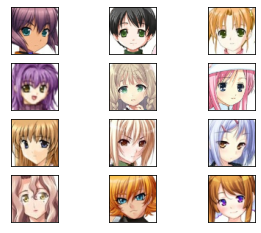

In [ ]:
display_faces(validation_dataset, size=12)

## Build the Model

<img src="https://drive.google.com/uc?export=view&id=1YAZAeMGEJ1KgieYk1ju-S9DoshpMREeC" width="60%" height="60%"/>

### Sampling Class
Recall the equation to combine these:

$$z = \mu + e^{0.5\sigma} * \epsilon  $$

where $\mu$ = mean, $\sigma$ = standard deviation, and $\epsilon$ = random sample

In [ ]:
class Sampling(tf.keras.layers.Layer):
  def call(self, inputs):
    """Generates a random sample and combines with the encoder output
    
    Args:
      inputs -- output tensor from the encoder

    Returns:
      `inputs` tensors combined with a random sample
    """
    ### START CODE HERE ###
    mu, sigma = inputs
    batch = tf.shape(mu)[0]
    dim = tf.shape(mu)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    z = mu + tf.exp(0.5*sigma)*epsilon
    ### END CODE HERE ###
    return  z

### Encoder Layers



In [ ]:
def encoder_layers(inputs, latent_dim):
  """Defines the encoder's layers.
  Args:
    inputs -- batch from the dataset
    latent_dim -- dimensionality of the latent space

  Returns:
    mu -- learned mean
    sigma -- learned standard deviation
    batch_3.shape -- shape of the features before flattening
  """
  ### START CODE HERE ###
  x = Conv2D(filters=32,kernel_size=(3,3), strides=2, padding='same',activation='relu')(inputs)
  x = BatchNormalization()(x)
  
  x = Conv2D(filters=64,kernel_size=(3,3), strides=2, padding='same',activation='relu')(x)
  x = BatchNormalization()(x)
  
  x = Conv2D(filters=128,kernel_size=(3,3), strides=2, padding='same',activation='relu')(x)
  batch_3 = BatchNormalization()(x)

  x = Flatten()(batch_3)

  x = Dense(units=1024,activation='relu')(x)
  x = BatchNormalization()(x)

  mu = Dense(units=latent_dim)(x)
  sigma = Dense(units=latent_dim)(x)  
  
  ### END CODE HERE ###

  # revise `batch_3.shape` here if you opted not to use 3 Conv2D layers
  return mu, sigma, batch_3.shape

### Encoder Model

In [ ]:
def encoder_model(latent_dim, input_shape):
  """Defines the encoder model with the Sampling layer
  Args:
    latent_dim -- dimensionality of the latent space
    input_shape -- shape of the dataset batch

  Returns:
    model -- the encoder model
    conv_shape -- shape of the features before flattening
  """
  ### START CODE HERE ###
  inputs = Input(shape=input_shape)

  mu, sigma, conv_shape = encoder_layers(inputs,latent_dim)
  
  z = Sampling()((mu, sigma))
  
  model = tf.keras.Model(inputs=inputs,outputs=[mu,sigma,z])
  ### END CODE HERE ###
  model.summary()
  return model, conv_shape

### Decoder Layers

In [ ]:
def decoder_layers(inputs, conv_shape):
  """Defines the decoder layers.
  Args:
    inputs -- output of the encoder 
    conv_shape -- shape of the features before flattening

  Returns:
    tensor containing the decoded output
  """
  ### START CODE HERE ###
  units = conv_shape[1]*conv_shape[2]*conv_shape[3]

  x = Dense(units=units,activation='relu')(inputs)
  x = BatchNormalization()(x)

  x = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)

  x = Conv2DTranspose(filters=128, kernel_size=(3,3), strides=2, activation='relu', padding='same')(x)
  x = BatchNormalization()(x)
  
  x = Conv2DTranspose(filters=64, kernel_size=(3,3), strides=2, activation='relu', padding='same')(x)
  x = BatchNormalization()(x)
  
  x = Conv2DTranspose(filters=32, kernel_size=(3,3), strides=2, activation='relu', padding='same')(x)
  x = BatchNormalization()(x)

  x = Conv2DTranspose(filters=3, kernel_size=(3,3), strides=1, activation='sigmoid', padding='same')(x)
  
  
  
  
  
  
  
  
  
  
  
  ### END CODE HERE ###
  return x

### Decoder Model

Please complete the function below to output the decoder model.

In [ ]:
def decoder_model(latent_dim, conv_shape):
  """Defines the decoder model.
  Args:
    latent_dim -- dimensionality of the latent space
    conv_shape -- shape of the features before flattening

  Returns:
    model -- the decoder model
  """
  ### START CODE HERE ###
  inputs = Input(shape=(latent_dim,))
  outputs = decoder_layers(inputs, conv_shape)
  model = tf.keras.Model(inputs=inputs, outputs=outputs)
  ### END CODE HERE ###
  model.summary()
  return model

### Kullback–Leibler Divergence

[Kullback–Leibler Divergence](https://arxiv.org/abs/2002.07514) loss. This will be used to improve the generative capability of the model.


In [ ]:
def kl_reconstruction_loss(inputs, outputs, mu, sigma):
  """ Computes the Kullback-Leibler Divergence (KLD)
  Args:
    inputs -- batch from the dataset
    outputs -- output of the Sampling layer
    mu -- mean
    sigma -- standard deviation

  Returns:
    KLD loss
  """
  kl_loss = 1 + sigma - tf.square(mu) - tf.math.exp(sigma)
  return tf.reduce_mean(kl_loss) * -0.5

### Putting it all together



In [ ]:
def vae_model(encoder, decoder, input_shape):
  """Defines the VAE model
  Args:
    encoder -- the encoder model
    decoder -- the decoder model
    input_shape -- shape of the dataset batch

  Returns:
    the complete VAE model
  """
  ### START CODE HERE ###
  inputs = Input(shape=input_shape)
  
  mu, sigma, z = encoder(inputs)

  reconstructed = decoder(z)

  model = tf.keras.Model(inputs=inputs, outputs=reconstructed)

  loss = kl_reconstruction_loss(inputs, z, mu, sigma)
  model.add_loss(loss)
  
  
  
  
  
  
  
  ### END CODE HERE ###
  return model

In [ ]:
def get_models(input_shape, latent_dim):
  """Returns the encoder, decoder, and vae models"""
  ### START CODE HERE ###
  encoder, conv_shape = encoder_model(latent_dim=latent_dim, input_shape=input_shape)
  
  decoder = decoder_model(latent_dim=latent_dim, conv_shape=conv_shape)
  
  vae = vae_model(encoder, decoder, input_shape=input_shape)
  
  ### END CODE HERE ###
  return encoder, decoder, vae

In [ ]:
encoder, decoder, vae = get_models(input_shape=(64,64,3,), latent_dim=LATENT_DIM)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 32)   896         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 conv2d_1 (Conv2D)              (None, 16, 16, 64)   18496       ['batch_normalization[0][0]']

## Train the Model


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)
loss_metric = tf.keras.metrics.Mean()
mse_loss = tf.keras.losses.MeanSquaredError()
bce_loss = tf.keras.losses.BinaryCrossentropy()

In [ ]:
def generate_and_save_images(model, epoch, step, test_input):
  """Helper function to plot our 16 images

  Args:

  model -- the decoder model
  epoch -- current epoch number during training
  step -- current step number during training
  test_input -- random tensor with shape (16, LATENT_DIM)
  """
  predictions = model.predict(test_input)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      img = predictions[i, :, :, :] * 255
      img = img.astype('int32')
      plt.imshow(img)
      plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  fig.suptitle("epoch: {}, step: {}".format(epoch, step))
  plt.savefig('image_at_epoch_{:04d}_step{:04d}.png'.format(epoch, step))
  plt.show()

The general steps are:

* feed a training batch to the VAE model
* compute the reconstruction loss (hint: use the **mse_loss** defined above instead of `bce_loss` in the ungraded lab, then multiply by the flattened dimensions of the image (i.e. 64 x 64 x 3)
* add the KLD regularization loss to the total loss (you can access the `losses` property of the `vae` model)
* get the gradients
* use the optimizer to update the weights



In [ ]:
# Training loop. Display generated images each epoch

### START CODE HERE ###
epochs = 50
### END CODE HERE ###

random_vector_for_generation = tf.random.normal(shape=[16, LATENT_DIM])
generate_and_save_images(decoder, 0, 0, random_vector_for_generation)

for epoch in range(epochs):
  print('Start of epoch %d' % (epoch,))

  # Iterate over the batches of the dataset.
  for step, x_batch_train in enumerate(training_dataset):
    with tf.GradientTape() as tape:
      ### START CODE HERE ### 
      reconstructed = vae(x_batch_train)

      # Compute reconstruction loss
      flattened_inputs = tf.reshape(x_batch_train, shape=[-1])
      flattened_outputs = tf.reshape(reconstructed, shape=[-1])
      loss = mse_loss(flattened_inputs, flattened_outputs) * 12288
      
      # add KLD regularization loss
      loss += sum(vae.losses)
      
      
      
      
      

    grads = tape.gradient(loss, vae.trainable_weights)
    optimizer.apply_gradients(zip(grads, vae.trainable_weights))
    ### END CODE HERE
    
    loss_metric(loss)

    if step % 10 == 0:
      # display.clear_output(wait=False)    
      generate_and_save_images(decoder, epoch, step, random_vector_for_generation)
    print('Epoch: %s step: %s mean loss = %s' % (epoch, step, loss_metric.result().numpy()))

# Plot Reconstructed Images


It will look something like below:

<img src="https://drive.google.com/uc?export=view&id=1OPMbZOxX9fx8tK6CGVbrMaQdgyOiQJIC" width="75%" height="60%"/>

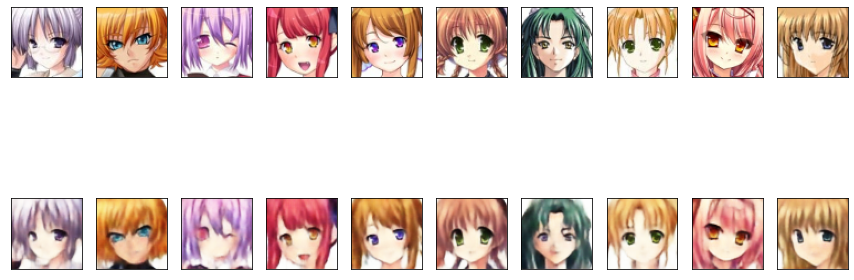

In [ ]:
test_dataset = validation_dataset.take(1)
output_samples = []

for input_image in tfds.as_numpy(test_dataset):
      output_samples = input_image

idxs = np.random.choice(64, size=10)

vae_predicted = vae.predict(test_dataset)
display_results(output_samples[idxs], vae_predicted[idxs])

# Plot Generated Images


Here is a sample gallery generated after $n = 50$ epochs.

<img src="https://drive.google.com/uc?export=view&id=1QwElgfg5TY6vCgI1FK6vdI8Bo6UZKfuX" width="75%" height="60%"/>

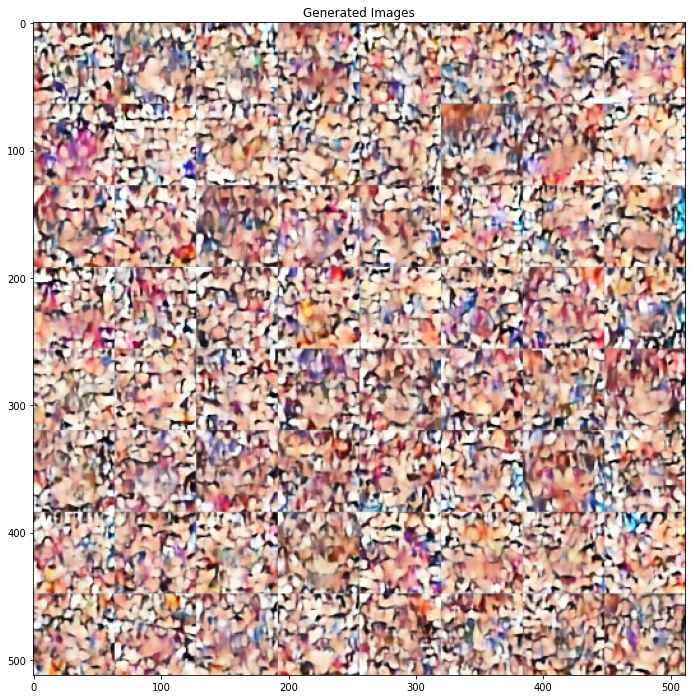

In [ ]:
def plot_images(rows, cols, images, title):
    '''Displays images in a grid.'''
    grid = np.zeros(shape=(rows*64, cols*64, 3))
    for row in range(rows):
        for col in range(cols):
            grid[row*64:(row+1)*64, col*64:(col+1)*64, :] = images[row*cols + col]

    plt.figure(figsize=(12,12))       
    plt.imshow(grid)
    plt.title(title)
    plt.show()

# initialize random inputs
test_vector_for_generation = tf.random.normal(shape=[64, LATENT_DIM])

# get predictions from the decoder model
predictions= decoder.predict(test_vector_for_generation)

# plot the predictions
plot_images(8,8,predictions,'Generated Images')

### Save the Model

In [ ]:
# vae.save("anime.h5")